# Mapping Murdock's Ethnographic Atlas
## using geopandas and folium 
### (relevant to a replication of James Fenske's paper)

This notebook illustrates how to do mapping and some geospatial analysis inside of a juptyer notebook using various python libraries.  All of these steps can of course be done inside of dedicated GIS client such as QGIS but it's nice to be able to do many of the same tasks inside of a notebook for better documentation and automation.
$x^2$

The notebook illustrates how to load and display vector polygon as well as raster geospatial data. There are many ways to do this with python but we focus here on using [geopandas](https://github.com/geopandas/geopandas) with [folium](http://python-visualization.github.io/folium/) in a supporting role (to make things look more cool on interactive slippy maps using [leaflet.js](http://leafletjs.com/)).  We use the [rasterio](https://github.com/mapbox/rasterio) and [rasterstats](http://pythonhosted.org/rasterstats/) libraries to work with raster data. 

Broad outline:

1. load vector polygon from [Morduck's Ethnographic Atlas](http://devecondata.blogspot.com/2007/10/ethnographic-atlas.html)  data digitized by Nathan Nunn. We'll display the data and show how to also plot markers on a different map layer.

2. Load and display gridded raster data on wheat suitability. 

3. Calculate raster zonal statistics 

4. (not finished) Discuss how data such as that constructed in step 3 was used in an empirical paper by James Fenske...

In [1]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
plt.style.use('bmh')

First create a folium slippy basemap. 

In [2]:
m = folium.Map(
    location = [-1, 25], 
    zoom_start=4, 
    tiles='cartodbpositron'
)

We use `FeatureGroup`s to add feature layers that we can later turn off and on via LayerControl

We will have different folium map layers or FeatureGroups. 

The `marker_group` below is just a collection of markers (all appear at once). 
The `marker_cluster` will, depending on zoom level, cluster markers into groups to make the map less cluttered. We turn on only one of the marker feature groups at a time.

The polygon group will have tribal group borders. 

In [3]:
poly_group = folium.FeatureGroup(name='Tribes')
marker_group = folium.FeatureGroup(name='Markers')
marker_cluster = MarkerCluster().add_to(m)

#### Morduck's Ethnographic Atlas
Shapefile [digitized by Nathan Nunn](https://scholar.harvard.edu/nunn/pages/data-0) 
We import this shapefile into a geopandas dataframe:

In [4]:
shpfile = r'zip://borders_tribes.zip'
tribe_areas = gpd.GeoDataFrame.from_file(shpfile)
tribe_areas.head(3)

,NAME,TRIBE_CODE,LAT,LON,geometry
0,ABABDA,1,23.161800,33.70160,"POLYGON ((35.73971 22.87611, 35.54412 22.64326..."
1,ABARAMBO,2,3.702955,26.79730,"POLYGON ((26.45080 3.39284, 26.45227 3.39798, ..."
2,ABE,3,6.069531,-4.26032,"POLYGON ((-4.07477 6.37522, -4.01895 6.26358, ..."


geopandas is a powerful python library. Among many other things it allows us to plot. The `column =` option allows shading by any column.

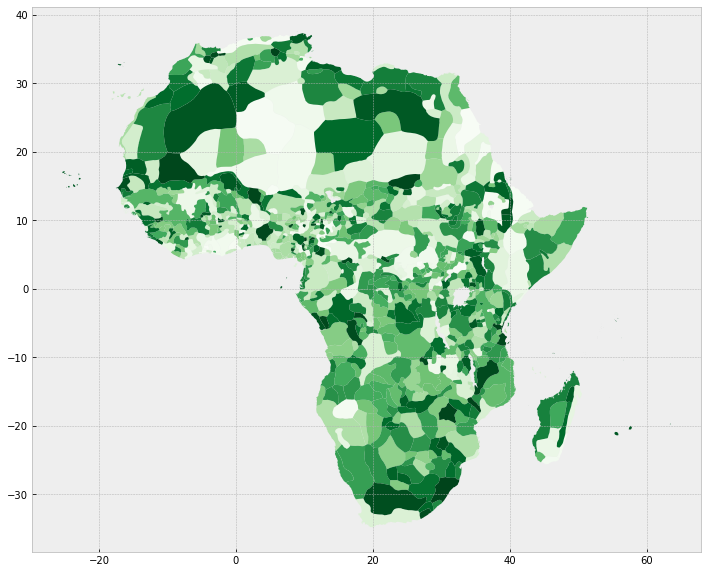

In [5]:
tribe_areas.plot(cmap='Greens', figsize=(12,16));

But this is a static map. For exploratory purposes it's nice to pass the information in the dataframe to folium to map things on top of a slippy map.  

The following adds the polygon information from our geopandas dataframe to the `poly_group` map layer that we will use below with folium.

In [6]:
folium.GeoJson(tribe_areas).add_to(poly_group);

C:\Users\jconn\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


##### Markers
We'll iterate through the ethnic groups and create a marker for each group to be located at the Lat, Lon position recorded in the geopandas data frame and labeled with the ethnic group name. 

In [7]:
for i, row in tribe_areas.iterrows():
    folium.Marker(
        location=[row.LAT, row.LON],
        popup = row.NAME).add_to(marker_cluster)  # or replace with marker_group

We choose which of these FeatureGroups to add to the folium map and add a `LayerControl` to allow us to selectively turn these layers on or off.

**NOTE**: the map that follows will not be seen in static views of this notebook (as you might see on github). See this [saved HTML rendering](https://cdn.rawgit.com/jhconning/land_uct_2018/cbc64c77/notebooks/tribes.html) (which should be interactive). If you don't see a map in Chrome, try the same in another browser.

In [8]:
marker_group.add_to(m)
marker_cluster.add_to(m)
poly_group.add_to(m)

folium.LayerControl().add_to(m)

Save the map to an HTML file to be browsed as a standalone in a larger window.

In [10]:
m.save('tribes.html')

We could have displayed a folium slippy map inline in this notebook with just it's name `m` but this isn't always visible from static views of the papge. So we saved [tribes.html](tribes.html) (Click [HERE](https://cdn.rawgit.com/jhconning/land_uct_2018/cbc64c77/notebooks/tribes.html) to view online).  Pan and zoom to see the Marker clusters unbundle.

In [11]:
%%html
<iframe src="tribes.html" width=800 height=600></iframe>

## Raster data, zonal statistics

We want to calculate zonal statistics (in this case statistics for data that falls inside the ethnic group boundaries).  Here we'll get data on wheat yield potential which comes as raster data from FAO-GAEZ. Each gridpoint on the raster is associated with a suitability index.  We'll calculate mean suitability in each of the polygons associated with Murdock/Nunn data.

In [12]:
import rasterio
import rasterio.plot as rioplot
import rasterstats as rs

First get downloaded raster data on potential crop yields from FAO-GAEZ data.  Looks like this. 

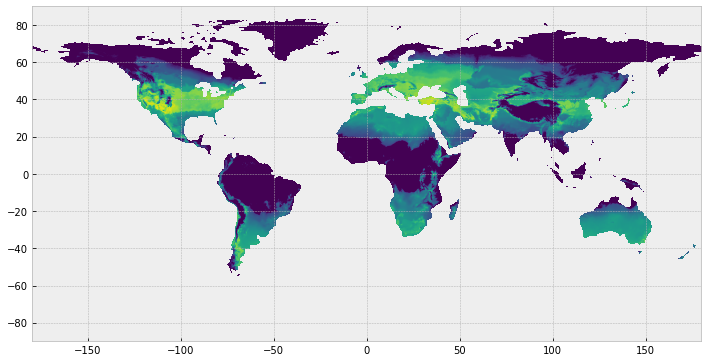

In [14]:
wheat = rasterio.open("res02_crav6190h_whea000a_yld.tif")
plt.figure(figsize=(12,10))
rioplot.show(wheat);

Next we use the `rasterstats.zonal_stats` command to calculate 'count', 'max', 'min', 'mean' statistics for the raster data inside each polygon. The function returns the results as a python dictionary.

In [16]:
stats = rs.zonal_stats('borders_tribes.shp',
                       'res02_crav6190h_whea000a_yld.tif', 
                       prefix = 'wheat_',
                       stats="count min mean max median")

Finally let us add these calculated statistics as columns to our geodataframe.

In [17]:
colnames = pd.DataFrame(stats).columns.tolist()
colnames

['wheat_min', 'wheat_max', 'wheat_mean', 'wheat_count', 'wheat_median']

In [18]:
tribe_areas[colnames] = pd.DataFrame(stats)
tribe_areas.head()

,NAME,TRIBE_CODE,LAT,LON,geometry,wheat_min,wheat_max,wheat_mean,wheat_count,wheat_median
0,ABABDA,1,23.161800,33.70160,"POLYGON ((35.73971 22.87611, 35.54412 22.64326...",0.0,7443.0,5184.301811,1988,5200.0
1,ABARAMBO,2,3.702955,26.79730,"POLYGON ((26.45080 3.39284, 26.45227 3.39798, ...",0.0,0.0,0.000000,82,0.0
2,ABE,3,6.069531,-4.26032,"POLYGON ((-4.07477 6.37522, -4.01895 6.26358, ...",0.0,0.0,0.000000,48,0.0
3,ACHOLI,4,3.108121,32.65680,"POLYGON ((33.25900 3.88539, 33.45547 3.86574, ...",0.0,5564.0,32.824451,319,0.0
4,ADAMAWA,5,7.556091,13.18470,"POLYGON ((14.14605 9.96943, 14.14605 9.87880, ...",0.0,6395.0,159.106452,620,0.0


Let's see a simple chloropeth plot based on mean wheat potential in each ethnic group zone.

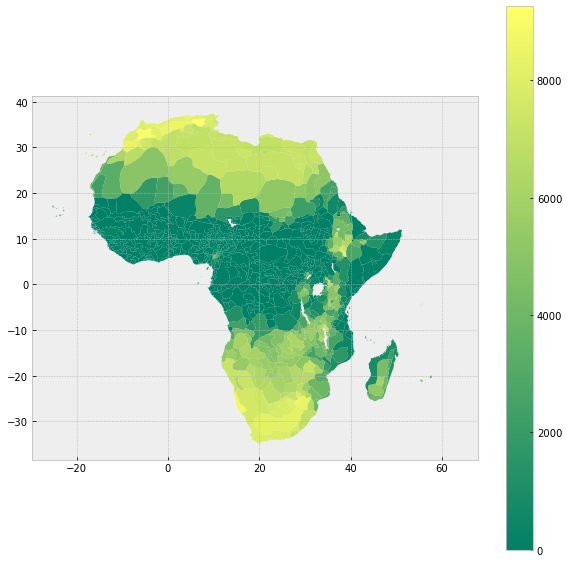

In [19]:
tribe_areas.plot(column='wheat_mean', cmap='summer', legend=True, figsize=(10,10));

## James Fenske's regressions

    Fenske, James. 2013. “Does Land Abundance Explain African Institutions?” The Economic Journal 123 (573):1363–1390.

To his great credit James Fenske posts data and code to replicate most of his published papers to his [website](https://sites.google.com/site/jamesfenske/Research)

Several of his right hand variables in the regressions in tables X, Y Z were constructed using methods such as those described above.


More to follow...

# More geo-spatial


In [20]:
tribe_areas.crs

{'init': 'epsg:4326'}

### Distances and Border Buffers

We can plot any one of these territories, For example

In [21]:
tribe_areas.loc[77, 'NAME']

'BASARI'

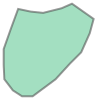

In [22]:
tribe_areas.loc[77, 'geometry']

### Finding centroids

In [23]:
tribe_areas['centr'] = tribe_areas['geometry'].centroid

Let us designate one centroid of these tribe areas as an arbitrary start point.  Suppose we want to find all tribal areas within a given distance from that point (measured in degrees).

In [24]:
start_point = tribe_areas.loc[77,'centr']

We generate a panda series with the distances to this point for each tribe area. 

In [25]:
distance_to0 = tribe_areas['geometry'].distance(start_point)

Here we create a two-layer map (by sharing a matplotlib figure axis) with the one layer being the tribe_areas shapefile and then another layer just those areas satisfying the  (distance_to0 < 10) mask.

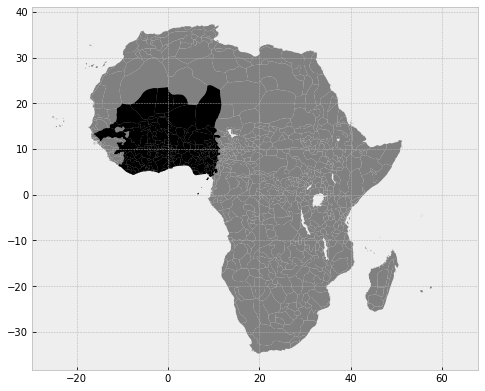

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
base = tribe_areas.plot(ax=ax, color = 'gray')
tribe_areas[(distance_to0 < 10)].plot(ax=base,color='black');

## Spatial joins

In a Spatial Join, two geometry objects are merged based on their spatial relationship to one another. See examples [here](https://github.com/geopandas/geopandas/blob/master/examples/spatial_joins.ipynb) and [here](http://jose-coto.com/plotting-geopandas)

Here we want to find and plot all cities in the world that fall inside the Africa region.

In [27]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [28]:
cities.crs

{'init': 'epsg:4326'}

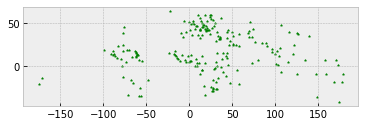

In [29]:
cities.plot(marker='*', color='green', markersize=5);

In [30]:
cities.head(2)

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)


In [31]:
from geopandas.tools import sjoin

In [32]:
afcities =  sjoin(cities, tribe_areas, how='inner', op='within')

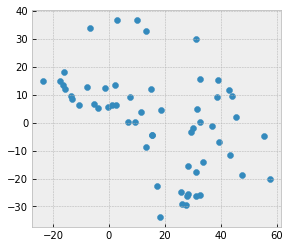

In [33]:
afcities.plot();

In [34]:
afcities.head(2)

,name,geometry,index_right,NAME,TRIBE_CODE,LAT,LON,wheat_min,wheat_max,wheat_mean,wheat_count,wheat_median,centr
10,Moroni,POINT (43.24024 -11.70416),154,COMORIANS,155,-12.0689,43.9597,0.0,5484.0,416.541667,24,0.0,POINT (43.95967 -12.06890)
13,Kigali,POINT (30.05859 -1.95164),654,RUANDA,655,-1.9311,29.9354,0.0,8286.0,4850.164948,291,4703.0,POINT (29.93537 -1.93110)


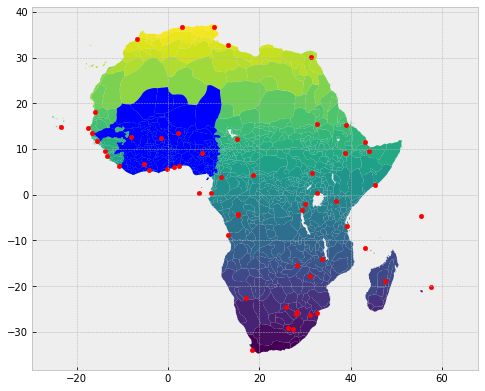

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
base = tribe_areas.plot(ax=ax, column='LAT')
tribe_areas[(distance_to0 < 10)].plot(ax=base)
afcities.plot(ax=ax, marker='o', color='red', markersize=20);

We can do these queries on the fly.  For example cities that fall inside the tribe areas a given distance from a point.

In [36]:
sjoin(cities,
  tribe_areas[(distance_to0 < 5)], 
  op='within')

,name,geometry,index_right,NAME,TRIBE_CODE,LAT,LON,wheat_min,wheat_max,wheat_mean,wheat_count,wheat_median,centr
36,Lome,POINT (1.22081 6.13388),202,EWE,203,6.611750,0.853875,0.0,0.0,0.0,190,0.0,POINT (0.85388 6.61175)
50,Niamey,POINT (2.11471 13.51865),835,ZERMA,828,13.584200,2.723258,0.0,0.0,0.0,534,0.0,POINT (2.72326 13.58422)
113,Cotonou,POINT (2.51804 6.40195),256,GUN,257,6.611319,2.760478,0.0,0.0,0.0,33,0.0,POINT (2.76048 6.61132)
119,Ouagadougou,POINT (-1.52667 12.37226),547,MOSSI,548,12.726500,-1.170430,0.0,0.0,0.0,796,0.0,POINT (-1.17043 12.72654)
152,Accra,POINT (-0.21866 5.55198),221,GA,222,5.700486,-0.193414,0.0,0.0,0.0,20,0.0,POINT (-0.19341 5.70049)


Highlight the larger 

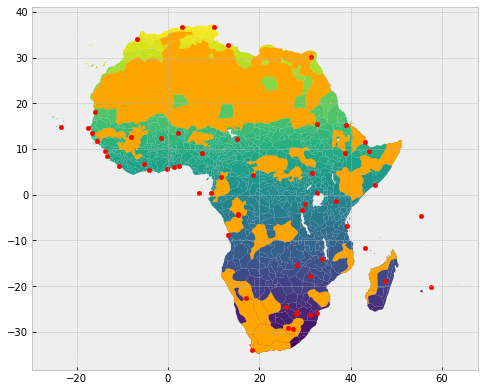

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
base = tribe_areas.plot(ax=ax, column='LAT')
tribe_areas[(tribe_areas.geometry.area>10)].plot(ax=base, color='orange')
afcities.plot(ax=ax, marker='o', color='red', markersize=20);


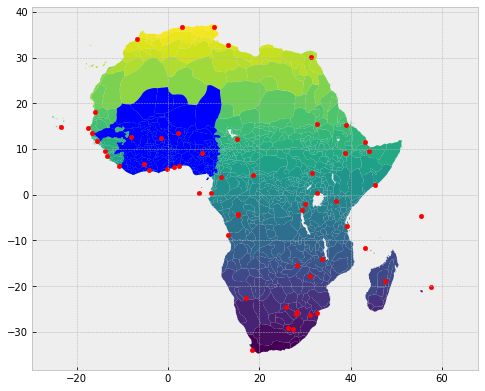

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
base = tribe_areas.plot(ax=ax, column='LAT')
tribe_areas[(distance_to0 < 10)].plot(ax=base)
afcities.plot(ax=ax, marker='o', color='red', markersize=20);

### Useful references

http://jose-coto.com/plotting-geopandas